In [1]:
# Copyright 2022 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ================================

# Each user is responsible for checking the content of datasets and the
# applicable licenses and determining if suitable for the intended use.

## 1. Data Analysis & Preparation

We are using [Booking.com dataset](https://github.com/bookingcom/ml-dataset-mdt) to train a session-based model. The raw train dataset contains 1,166,835 of anonymized hotel reservations given 217,686 unique trip ids made across 39,000 destinations. Each reservation is a part of a customer's trip (identified by utrip_id) which includes consecutive reservations. For more details, please refer to [Booking.com Multi-Destination Trips Dataset](https://dl.acm.org/doi/10.1145/3404835.3463240) published as a resource paper at SIGIR'21.

The main task is to use a dataset based on over a million of real anonymized accommodation reservations to come up with a strategy for making the best recommendation for travelers' next destination.

The goal is to create a deep learning (DL) model that can predict the `city_id` of the final reservation of each trip.

**Learning Objectives**

- Analyze the raw dataset, and prepare the train and validation datasets for feature engineering and transformation

### 1.1. Import Libraries

In [1]:
import os

import cudf 
import gc
import numpy as np
import pandas as pd

### 1.2. Download Dataset

Let's start with defining the data path.

In [2]:
DATA_FOLDER = os.environ.get(
    "DATA_FOLDER", 
    '/workspace/data/'
)

Download the booking dataset via a utility function.

In [3]:
from download_data import download_booking
download_booking(DATA_FOLDER)

2023-03-01 21:06:01.385455: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.8/dist-packages/merlin/dtypes/mappings/torch.py:43: UserWarning: PyTorch dtype mappings did not load successfully due to an error: No module named 'torch'
  warn(f"PyTorch dtype mappings did not load successfully due to an error: {exc.msg}")
downloading ground_truth.csv: 1.85MB [00:00, 100MB/s]                    
downloading test_set.csv: 29.2MB [00:00, 149MB/s]                            
downloading train_set.csv: 92.7MB [00:00, 201MB/s]                            


### 1.3. Analyze Dataset

We downloaded the dataset, now we can take a look at the training set.

In [4]:
raw_df = cudf.read_csv(os.path.join(DATA_FOLDER, "train_set.csv"), parse_dates=['checkin', 'checkout'])

Each reservation has a unique `utrip_id`. During each trip a customer vists several destinations.

In [5]:
print(raw_df.head())

   user_id    checkin   checkout  city_id device_class  affiliate_id  \
0  1000027 2016-08-13 2016-08-14     8183      desktop          7168   
1  1000027 2016-08-14 2016-08-16    15626      desktop          7168   
2  1000027 2016-08-16 2016-08-18    60902      desktop          7168   
3  1000027 2016-08-18 2016-08-21    30628      desktop           253   
4  1000033 2016-04-09 2016-04-11    38677       mobile           359   

  booker_country hotel_country   utrip_id  
0        Elbonia        Gondal  1000027_1  
1        Elbonia        Gondal  1000027_1  
2        Elbonia        Gondal  1000027_1  
3        Elbonia        Gondal  1000027_1  
4         Gondal  Cobra Island  1000033_1  


The training dataset consists of hotel reservations, based on real data (fully anonymized), with the following features:

- user_id - User ID
- checkin - Reservation check-in date
- checkout - Reservation check-out date- created_date - Date when the reservation was made
- city_id - city_id of the hotel's city
- affiliate_id - An anonymized ID of affiliate channels where the booker came from (e.g. direct, some third party referrals, paid search engine, etc.)
- device_class - desktop/mobile
- booker_country - Country from which the reservation was made
- hotel_country - Country of the hotel 
- utrip_id - Unique identification of user's trip (a group of multi-destinations bookings within the same trip).

#### Basic Stats

Let's check the size of the dataset. Our dataset has 1,166,835 rows.

In [6]:
print(raw_df.shape)

(1166835, 9)


Check out the dtypes of the dataset. We can see that we have string and integer columns that represent categorical features, and two columns with two datetime features. Dataset does not have a continuous column with float dtype.

In [7]:
raw_df.dtypes

user_id                    int64
checkin           datetime64[ns]
checkout          datetime64[ns]
city_id                    int64
device_class              object
affiliate_id               int64
booker_country            object
hotel_country             object
utrip_id                  object
dtype: object

Check out if data set has any nulls values.

In [8]:
raw_df.isnull().any()

user_id           False
checkin           False
checkout          False
city_id           False
device_class      False
affiliate_id      False
booker_country    False
hotel_country     False
utrip_id          False
dtype: bool

Our dataset does not have any nulls. If we had nulls, we could think of how to handle these null values. We could fill them out with a certain value, or remove the rows with nulls, etc.

Let's take a look at how many cities our dataset has. Note that we want to predict the next city to visit, therefore, `city_id` is our target column, as well. We deal with multi-class classification problem. That means we will use `Categorical Cross Entropy` as our loss function during model training.

In [9]:
raw_df.city_id.nunique()

39901

Similarly let's check the number of unique trips.

In [10]:
raw_df.utrip_id.nunique()

217686

Check min and max timestamp values. We will use these timestamps to split dataset as train and validation sets, also we can create temporal features from checkin and checkout columns, which can give information about users' temporal behaviours, and, thus, play a role in increasing model's accuracy in predicting the next city.

In [11]:
raw_df.checkin.min(), raw_df.checkin.max()

(numpy.datetime64('2015-12-31T00:00:00.000000000'),
 numpy.datetime64('2017-02-27T00:00:00.000000000'))

**Distribution of cities**

We can check the frequency distribution of the cities using city frequency statistic.

In [12]:
city_counts = raw_df.to_pandas().city_id.value_counts()
print(city_counts)

47499    11242
23921    10511
36063     9559
17013     9011
29319     8179
         ...  
10377        1
54696        1
4028         1
41726        1
5692         1
Name: city_id, Length: 39901, dtype: int64


Note that some cities are more popular than the others. That might give us some idea in building a baseline model. One simplest approach could be recommending the most popular items to the users. Although this approach does not really take the personalization aspect of the recommendations into account, it still can be a baseline approach. However we are not going to start with that approach. We will instead start with a simple `multi-layer-perceptron (MLP)` model.

In [16]:
#!pip install matplotlib

Text(0, 0.5, 'frequency')

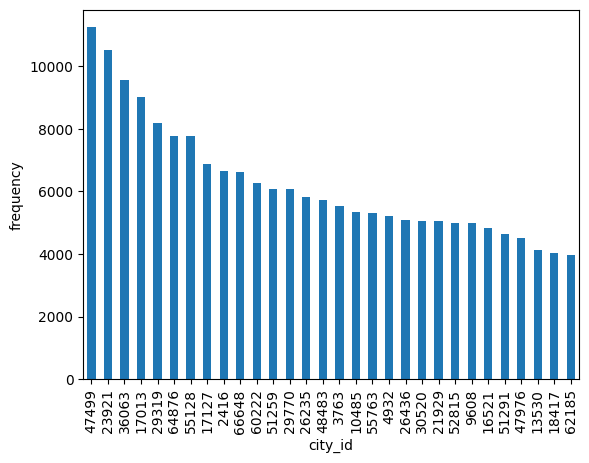

In [17]:
# plot the most frequent 30 cities frequencies.
ax = city_counts[:30].plot(kind='bar')
ax.set_xlabel("city_id")
ax.set_ylabel("frequency")

**Interactions per day**

We can plot how many trips are done per day to see if there is a seasonal pattern. The plot below shows that the most of the trips have been done during the June-September time period where we can observe the peak. Presumably these trips were done in the northern hemisphere where these months correspond to the summer season, and when the schools are closed.

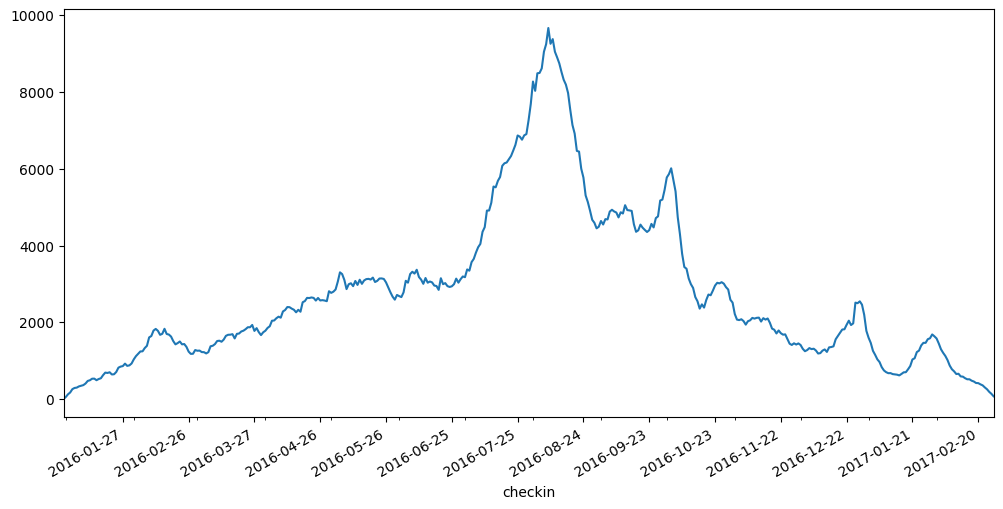

In [18]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
ax= raw_df.groupby('checkin').size().to_pandas().sort_index().plot.line(figsize=(12,6))

ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.show()

### 1.4. Split the train set as train and validation sets

Let's split the data into a train and validation set based on check-in time and trip id. We first sort the train dataset according to `checkin` date, and reserve the last two months as validation set.

In [19]:
train_set = raw_df.sort_values(['checkin', 'utrip_id']).reset_index(drop=True)

In [20]:
del raw_df
gc.collect()

200

Check if there are any duplicated (user, checkin) pairs.

In [21]:
train_set.to_pandas().duplicated(subset=['user_id', 'checkin']).sum()

0

In [22]:
train_set

,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id
0,2000964,2015-12-31,2016-01-01,63341,mobile,8151,The Devilfire Empire,Cobra Island,2000964_1
1,2595109,2015-12-31,2016-01-01,27404,mobile,359,The Devilfire Empire,Cobra Island,2595109_1
2,727105,2015-12-31,2016-01-01,18820,mobile,359,The Devilfire Empire,Cobra Island,727105_1
3,1032571,2016-01-01,2016-01-02,21996,mobile,9924,The Devilfire Empire,Cobra Island,1032571_1
4,110418,2016-01-01,2016-01-02,3763,desktop,9924,The Devilfire Empire,Glubbdubdrib,110418_1
...,...,...,...,...,...,...,...,...,...
1166830,5955565,2017-02-27,2017-02-28,54384,desktop,8132,Elbonia,Patusan,5955565_2
1166831,6172320,2017-02-27,2017-02-28,6005,mobile,9452,The Devilfire Empire,Patusan,6172320_1
1166832,885453,2017-02-27,2017-02-28,53020,desktop,9924,Gondal,Gondal,885453_1
1166833,890798,2017-02-27,2017-02-28,43524,desktop,9924,Gondal,Rolisica,890798_1


Apply timebased split.

In [23]:
train = train_set[(train_set['checkin'] < pd.Timestamp("2017-01-01"))]
valid = train_set[(train_set['checkin'] >= pd.Timestamp("2017-01-01"))]

In [24]:
train.shape, valid.shape

((1116574, 9), (50261, 9))

When we do the time-based split, some of the same user trips might be split between train and validation sets, meaning a certain portion of the same trip can be in the train set while remaning portion might end up in the validation set. To avoid this, we find the `utrip_ids` that are also in the train set, remove them from validation set, and add them back to train set.

In [25]:
valid_tmp = valid[valid.utrip_id.isin(train.utrip_id)]
print(valid_tmp.shape)
valid = valid[~valid.utrip_id.isin(train.utrip_id)].reset_index(drop=True)

(6128, 9)


In [30]:
valid.shape

(44133, 9)

Print the shape of the train and validation sets, and number of unique trip ids in each dataset.

In [31]:
train.shape, valid.shape

((1116574, 9), (44133, 9))

In [32]:
train = cudf.concat([train, valid_tmp]).reset_index(drop=True)

Check out if there are any duplicated (user, checkin) pairs. The dataset should not have duplicated pairs, meaning, same user cannot checkin multiple times on the same date, therefore we see the output as `0`.

In [33]:
train.to_pandas().duplicated(subset=['user_id', 'checkin']).sum()

0

In [34]:
valid.to_pandas().duplicated(subset=['user_id', 'checkin']).sum()

0

In [35]:
num_unique_trips_train, num_unique_trips_valid = train.utrip_id.nunique(), valid.utrip_id.nunique()
print (num_unique_trips_train,  num_unique_trips_valid)

209342 8344


We can check the number of visits per trip in the train dataset. We see that the median of the session lenghts is `5` and 75% of the sessions have less than 6 cities visited.

In [36]:
train.groupby('utrip_id')['city_id'].size().describe()

count    209342.000000
mean          5.363004
std           2.020633
min           1.000000
25%           4.000000
50%           5.000000
75%           6.000000
max          48.000000
dtype: float64

We can check the percentage of the trips (sessions) that have more than 10 cities.

In [37]:
num_unique_trips = train.utrip_id.nunique()
((train.groupby('utrip_id')['city_id'].size()>10).sum() / num_unique_trips_train) * 100

2.9005168575823292

We can also calculate the percentage of the trips that have only 1 city visited. 

In [38]:
((train.groupby('utrip_id')['city_id'].size()<2).sum() / num_unique_trips_train) * 100

0.051112533557527866

Most of the trips have multiple city visits. That gives us the idea that we can treat the `next city prediction task` as a session-based recommendation task and leverage the sequential patterrns per user trip (session).

Similarly, we see that validation set does not have any trip that have more than 10 cities visited.

In [39]:
((valid.groupby('utrip_id')['city_id'].size()>10).sum() / num_unique_trips_valid) * 100

2.3010546500479387

However, validation set has larger share of trips that have only one city.

In [40]:
((valid.groupby('utrip_id')['city_id'].size()<2).sum() / num_unique_trips_valid) * 100

0.07190795781399809

Considering this, we can set the max sequence length to 10 in the next notebook where we will transform the datasets and create features.

Now, let's check how many of the last visited city_id (target city) in the validation set are not in the train set. There might be target cities in the validation set that never appear in the train set. We call them out-of-vocabulary (OOV).  We want to avoid to predict OOV target cities when evaluating the model with validation set.

In [41]:
valid_grouped = valid.sort_values(['checkin', 'utrip_id']).groupby('utrip_id')['city_id'].agg(['last']).reset_index()

In [43]:
valid_grouped[~valid_grouped['last'].isin(train.city_id)].shape

(40, 2)

In [44]:
del valid_grouped, valid_tmp
gc.collect()

432

Save the train and validation files to disk as parquet files.

In [45]:
train.to_parquet(os.path.join(DATA_FOLDER, "train.parquet"))
valid.to_parquet(os.path.join(DATA_FOLDER, "valid.parquet"))

### Summary

In this notebook, we have performed the following steps:
    
- download the dataset
- analyze the dataset
- split the dataset based on timestamp as train and validation sets
- save the train and validation sets to disk as parquet files

Please execute the cell below to shut down the kernel before moving on to the next notebook `02-ETL-with-NVTabular`.

In [46]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}